In [1]:
%load_ext autoreload
%autoreload 2

In [276]:
import sys
import subprocess
import os
import pandas as np
import numpy as np
import pathlib
import re
import glob
import pandas as pd
from pprint import pprint
module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
import workbench
from workbench.utilities import general, config_utils, temporal, io
from workbench.manage import manage, host
# from workbench.manage import host
from workbench.workflows import workflows
from workbench.simulations import method_iv_solver, method_topology_solver
from workbench.visualize import plots as ipv_plot

# Overview

# Part 1 Initialise and Build Model

## 1.1 Initialise

In [3]:
# initialise the project folder
# this creates a project folder in the parent dir using the project name and the base EPW file
# the most important result of this process is the config file

parent_dir = os.path.join("/Users","jmccarty","Desktop","idp_tutorial")
project_name = "idp_intro_day"
project_epw = os.path.join("/Users","jmccarty","Downloads", "fluntern_2001-2017.epw")

config_path = manage.initiate_project(parent_dir, project_name, project_epw)

<div style="align-contents: center; width: 600px;"><img src="../assets/folder_struct_new config.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> The initial folder structure</p></div>

<div style="align-contents: center; width: 600px;"><img src="../assets/basic_config_file.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> Here we can see the default config file that was just created. There are several sections and under each paremters that we will adjust throughout the tutorial using an instance of a Python object that is meant for managing the project.</p></div>

In [4]:
# intialise the project manager object using the config file
# the basic operations in the project manager is the creation of file paths associated to the object which makes writing files, getting input data, 
# and accessing project details much easier
project_manager = manage.Project(config_path)

# for example when the projec tis initiated it reads the location details of the EPW file and enters them into the config 
print("Project latitude: ", project_manager.management_latitude)
print("Project longitude: ", project_manager.management_longitude)

Project latitude:  47.378
Project longitude:  8.566


In [5]:
# Feature Example
# you can directly manipulate the config file using the edit_cfg_file class method of the project manager
# you just need to enter the secion (in brackets in the file), the key (what you want to edit), and the new value

# in this example we will change the host name (we will cover hosts later, but this is essentially a building name)
print(project_manager.management_host_name)
project_manager.edit_cfg_file("management", "host_name", "B1008")
print(project_manager.management_host_name)

B1000
B1008


In [6]:
# the project manager contains a key method for setting up the rest of the project strucutre and th einitial files
# there are several base files stored in your copy of CACTUS, they will be copied into a new file driectory
project_manager.project_setup()

The project is initialized. We have created a base host object named 'B1008'.
You will need to either move or create the geometry and panelizer files into the appropriate directories.
The geometry files should follow the convention defined in the output of the template grasshopper and rhino files.
The panelizer files are those that have been created using the grasshopper utility. The Panelizer is
not ready for a pure python implementation as of yet.


<div style="align-contents: center; width: 600px;"><img src="../assets/folder_struct_initialised project.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> Upon intialising the project a large file structure will be created. Importantly some template files will be added to ghe geometry subfolder that we can use to build our own project.</p></div>

## 1.2 Model Builder

<div style="align-contents: center; width: 600px;"><img src="../assets/cactus_template_geo.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> In its current form CACTUS still requires the user to rely on Rhino and Grasshopper for building the 3D model. This will change in future versions. The provided templates simplify the process by showing a small example that can be replaced. Here we see the template file "0_cactus_geometry_template.3dm" and the corresponding Grasshopper file.</p><br><p style="text-align: left; margin: 0 auto; width: 90%;"> I have tried to reduce the number of dependencies for the Grasshopper scripts but several additional packages are required: <br \> - Pancake: https://www.food4rhino.com/en/app/pancake  <br \> - Human: https://www.food4rhino.com/en/app/human</p></div>

<div style="align-contents: center; width: 400px;"><img src="../assets/duplicate_templates.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> Because these are template files and can potentially be overwritten if the project_manager.project_setup method is called again the first thing to do is make copies and rename or saveas. Then open the renamed files that gein with "0_". This is the geometry modeler.</p></div>

<div style="align-contents: center; width: 400px;"><img src="../assets/set project config.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> The first step is to link the config file to the geometry modeling workflow by setting the Project Config File (File Path) component to the location of your config file. </p></div>

<div style="align-contents: center; width: 400px;"><img src="../assets/geometry_builder_export.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> Each group on the left side of the grasshopper definition provides a specific function for intaking geometry, manipulating it based on its type, and feeding it to the export component, which is shown here. This is the objective of the gemoetry builder template. </p></div>

<div style="align-contents: center; width: 400px;"><img src="../assets/geometry_builder_host.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> The object that contains the surfaces you want to apply PV panels to is known as the host. In this case that is the building highted in green. The grasshopper file uses a pipeline component to intake objects that are drawn in Rhino and stored in specific layers. </p></div>

<div style="align-contents: center; width: 400px;"><img src="../assets/geometry_builder_rename_host.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> Note that we changed the host name to B1008 in the config file in an earlier cell. We need to make this adjustment in the grasshopper tempalte as well.</p></div>

<div style="align-contents: center; width: 400px;"><img src="../assets/geometry_builder_layers.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> Here we show the basic layers that the template comes with and is prepared to intake. Extending past these is not recommended at this time.</p></div>

<div style="align-contents: center;  width: 800px; height: 250px; align-contents: middle"><img src="../assets/geometry_builder_terrain.png" alt="Basic Config File" style="float:left; width: 33%;"/><img src="../assets/geometry_builder_host_objects.png" alt="Basic Config File" style="float:left; width: 33%;"/><img src="../assets/geometry_builder_opaque_context.png" alt="Basic Config File" style="float:left; width: 33%;"/></div><div style="align-contents: center; width: 800px; height: 150px; align-contents: middle"><img src="../assets/geometry_builder_seasonal_vegetation.png" alt="Basic Config File" style="float:left; width: 50%;"/><img src="../assets/geometry_builder_constant_vegetation.png" alt="Basic Config File" style="float:left; width: 50%;"/></div><div style="align-contents: center; width: 800px"><p style="text-align: center; margin: 0 auto; width: 90%;">Other than the host here are the other layers. Left to right: terrain, context objects on the host, surrounding opaque context (shading), vegetation that sheds leaves throughout the year, vegetation that does not shed leaves.</p></div>

<div style="align-contents: center; width: 800px;"><img src="../assets/geometry_builder_annotations.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> The template does not necessarily know which surfaces on the host that it is supposed to keep for the future panelizaer and analysis. Therefore there is a component group that allows the user to set a list corresponding to the surfaces. For each surface find the text tag and enter into the list the correct category under the same index order.</p></div>

<div style="align-contents: center; width: 800px;"><img src="../assets/geometry_builder_surface_builder.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> The last piece of the builder deals with surfaces that may have non integrated arrays. In this case that is the rooftop array. The sliders control the parameters of the array such that the user is free to manipulate it however they would like.</p></div>

<div style="align-contents: center; width: 800px;"><img src="../assets/geometry_builder_new_surfaces.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> It is understandable that outside of these layers you may want to add some geometry to act as a surface for PV. Luckily, with the flexibility of Grasshopper this is possible. Here we add several surfaces in the form of fixed shading devices that a PV module could be placed on. Note the new layer "new_surfaces".</p></div><br><div style="align-contents: center; width: 800px;"><img src="../assets/geometry_builder_add_surface_A.png" alt="Basic Config File" style="float:left; width: 50%;"/><img src="../assets/geometry_builder_add_surface_B.png" alt="Basic Config File" style="float:left; width: 50%;"/> <br><p style="text-align: center; margin: 0 auto; width: 90%;"> Once the new surfaces are pulled into Grasshopper using the newly added pipeline component we can conncet them into the flow. At the far right of the script is a Merge component to add the surfaces to.</p></div>

<div style="align-contents: center; width: 800px;"><img src="../assets/geometry_builder_export_False.png" alt="Basic Config File" style="float:left; width: 50%;"/><img src="../assets/geometry_builder_export_True.png" alt="Basic Config File" style="float:left; width: 50%;"/> <br><p style="text-align: center; margin: 0 auto; width: 90%;"> Once finished with the geometry builder the model can be exported to a fresh rhino file using the boolean attached to the export component.</p>

<div style="align-contents: center; width: 600px;"><img src="../assets/folder_struct_geometry_done.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> The newly created geometry file.</p></div>

## 1.3 Panelizer

<div style="align-contents: center; width: 800px;"><img src="../assets/panelizer_overview_coarse.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> The Panelizer is a mostly automated Grasshopper script which intakes details about a potential PV module and automatically generates an array on the specified surfaces. The key output is a file type known as a pickle which is a Python native format. This pickle describes the details of the various arrays for a Host object. The file is used to relate irradiance data from the irradiance workflow, which the Panelizer script is also responble for generating the properly formattted Radiance folder that is used for the raytracing. This Grasshopper version is a Beta version of the Panelizer, which will move to pure python in the coming months. </p></div>

<div style="align-contents: center; width: 800px;"><img src="../assets/typical_devices.png" alt="Basic Config File" style="float:left; width: 50%;"/><img src="../assets/bipv_co2_impact.png" alt="Basic Config File" style="float:left; width: 50%;"/> <br><p style="text-align: center; margin: 0 auto; width: 90%;"> The first thing to do select a device to work from. Included with CACTUS are several "typical" devices that were charatersied from a large database of modules on the market from the past 5 years. It is possible to create new devices, but we will go over that in a later tutorial. Here you can see the typical devices on the left and then how they relate to emboided carbon from Galimshina et al. (2023).</p></div>

In [22]:
# because we have restarted our notebook we will reactivate our project by reading in the config path
# place your config path here
config_path = "/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/cactus_tutorial.config"
project_manager = manage.Project(config_path)

# rerun the setup in order to rebuild the entire project object and its attributes
project_manager.project_setup()


Destination file already exists, copy aborted./n/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/inputs/shared/tmy/base.epw
Destination file already exists, copy aborted./n/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/inputs/hosts/B1008/base/geometry/0_cactus_geometry_template.3dm
Destination file already exists, copy aborted./n/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/inputs/hosts/B1008/base/geometry/0_cactus_geometry_template.gh
Destination file already exists, copy aborted./n/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/inputs/hosts/B1008/base/geometry/1_cactus_panelizer_template.gh
The project is initialized. We have created a base host object named 'B1008'.
You will need to either move or create the geometry and panelizer files into the appropriate directories.
The geometry files should follow the convention defined in the output of the template grasshopper and rhino files.
The panelizer files

In [ ]:
# wee need to input the device id into our config file
# in the shared folder of our project you will find CSV file for typical devices "cactus_typical_devices" 
# let's see what we have "cactus_tutorial/inputs/shared/cell_module_data/cactus_typical_devices.csv"

In [23]:
# we need to change the device id config option so grasshopper/panelizer can read it
print(project_manager.analysis_device_id)
project_manager.edit_cfg_file("analysis", "device_id", "D003")
print(project_manager.analysis_device_id)

D003
D003


<div style="align-contents: center; width: 500px;"><img src="../assets/panelizer_tutorial/panelizer_files.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> Now we can open the Panelizer files. Start with the rhino file and then load the grasshopper.</p></div>

<div style="align-contents: center; width: 800px;"><img src="../assets/panelizer_tutorial/panelizer_overview.png" alt="Basic Config File" style="float:left; width: 100%;"/><p style="text-align: center; margin: 0 auto; width: 90%;"> The panelizer has several parts. The first two are separated vertically. The upper workflow is for the actual panelization process. The smaller lower section is purely for writing a Radiance simulation project that CACTUS can read.</p></div>

In [70]:
# show slideshow

[autoreload of workbench.workflows.workflows failed: Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/workbench311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/workbench311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/workbench311/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames

'/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/outputs/B1008/base/irradiance/1008_6/direct.lz4'

In [68]:
building = host.Host(project_manager)

In [71]:
workflows.run_irradiance(building, overwrite=False)

Existing results files detected and the 'overwrite' arg is set to False, skipping surface 1008_10.
Existing results files detected and the 'overwrite' arg is set to False, skipping surface 1008_14.
Existing results files detected and the 'overwrite' arg is set to False, skipping surface 1008_12.
Existing results files detected and the 'overwrite' arg is set to False, skipping surface 1008_9.
Existing results files detected and the 'overwrite' arg is set to False, skipping surface 1008_6.
Starting Radiance workflow for surface 1008_13.
 - Running 2-Phase DDS with 7 workers
 - Current surface is 1008_13
 - Initializing the opening weather file.
 - Starting Part 1 (total).
     - oconv
     - rfluxmtx
     - gendaymtx
     - dctimestep | rmtxop
 - Starting Part 2 (direct).
     - oconv
     - rfluxmtx
     - gendaymtx
     - dctimestep | rmtxop
 - Starting Part 3 (sun).
     - create_primitive_sun
     - rcalc
     - oconv
     - rcontrib
     - gendaymtx
     - dctimestep | rmtxop
Comple

In [65]:
workflows.run_module_point(building, "center_point")

Starting module center_point analysis workflow for surface 1008_10.
{1008;10}
Completed in 0.32 seconds.
-----------------------
Starting module center_point analysis workflow for surface 1008_14.
{1008;14}
Completed in 4.07 seconds.
-----------------------
Starting module center_point analysis workflow for surface 1008_12.
{1008;12}
Completed in 0.28 seconds.
-----------------------
Starting module center_point analysis workflow for surface 1008_9.
{1008;9}
Completed in 0.42 seconds.
-----------------------
Starting module center_point analysis workflow for surface 1008_6.
{1008;6}
Completed in 0.05 seconds.
-----------------------
Starting module center_point analysis workflow for surface 1008_13.
{1008;13}
Completed in 0.17 seconds.
-----------------------
Starting module center_point analysis workflow for surface 1008_3.
{1008;3}
Completed in 0.44 seconds.
-----------------------
Starting module center_point analysis workflow for surface 1008_7.
{1008;7}
Completed in 3.12 seconds.


In [128]:
workflows.run_module_point(building, "cell_point")

Starting module cell_point analysis workflow for surface 1008_10.
shape1 (156, 3)
Completed in 1.3 seconds.
-----------------------
Starting module cell_point analysis workflow for surface 1008_14.
shape1 (1478, 3)
Completed in 22.58 seconds.
-----------------------
Starting module cell_point analysis workflow for surface 1008_12.
shape1 (127, 3)
Completed in 1.33 seconds.
-----------------------
Starting module cell_point analysis workflow for surface 1008_9.
shape1 (132, 3)
Completed in 1.71 seconds.
-----------------------
Starting module cell_point analysis workflow for surface 1008_6.
shape1 (44, 3)
Completed in 0.19 seconds.
-----------------------
Starting module cell_point analysis workflow for surface 1008_13.
shape1 (47, 3)
Completed in 0.9 seconds.
-----------------------
Starting module cell_point analysis workflow for surface 1008_3.
shape1 (144, 3)
Completed in 2.07 seconds.
-----------------------
Starting module cell_point analysis workflow for surface 1008_7.
shape1 (1

<Axes: xlabel='index'>

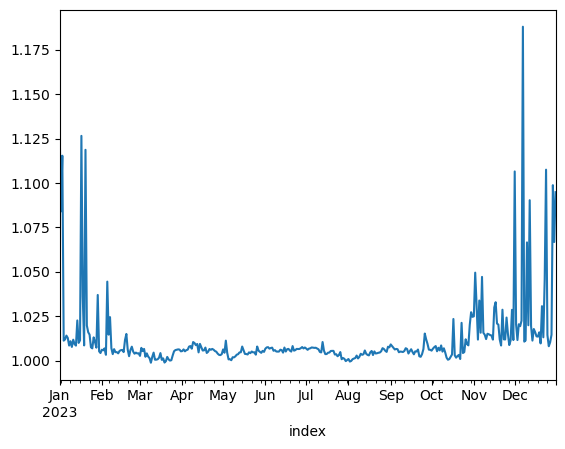

In [129]:
center_pt = pd.read_csv(os.path.join(project_manager.GENERAL_RESULTS_DIR,"base_center_point_building_level_results_hourly.csv"))
cell_pt = pd.read_csv(os.path.join(project_manager.GENERAL_RESULTS_DIR,"base_cell_point_building_level_results_hourly.csv"))

idx = pd.to_datetime(center_pt['index'])

center_pt.set_index(idx,inplace=True)
cell_pt.set_index(idx,inplace=True)

center_pt = center_pt.resample("D").sum()
cell_pt = cell_pt.resample("D").sum()

# relative difference
(center_pt['electricity_gen_bulk_building_kwh'] / cell_pt['electricity_gen_bulk_building_kwh']).plot()

<Axes: xlabel='index'>

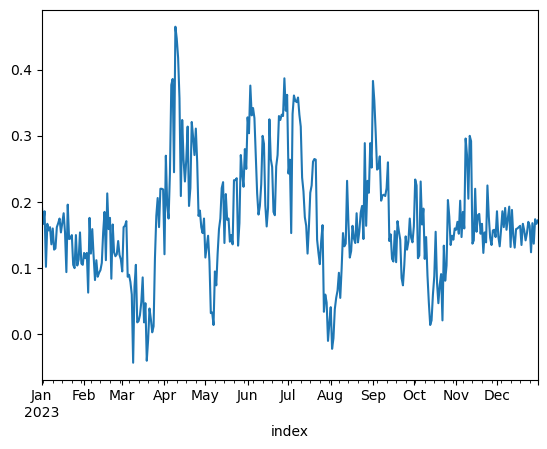

In [130]:
# absolute difference
(center_pt['electricity_gen_bulk_building_kwh'] - cell_pt['electricity_gen_bulk_building_kwh']).plot()

# 1.4 IV Based Analysis

In [90]:
# because we have restarted our notebook we will reactivate our project by reading in the config path
# place your config path here
config_path = "/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/cactus_tutorial.config"
project_manager = manage.Project(config_path)

# rerun the setup in order to rebuild the entire project object and its attributes
project_manager.project_setup()


Destination file already exists, copy aborted./n/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/inputs/shared/tmy/base.epw
Destination file already exists, copy aborted./n/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/inputs/hosts/B1008/base/geometry/0_cactus_geometry_template.3dm
Destination file already exists, copy aborted./n/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/inputs/hosts/B1008/base/geometry/0_cactus_geometry_template.gh
Destination file already exists, copy aborted./n/Users/jmccarty/Data/221205_ipv_workbench/tutorials/cactus_tutorial/inputs/hosts/B1008/base/geometry/1_cactus_panelizer_template.gh
The project is initialized. We have created a base host object named 'B1008'.
You will need to either move or create the geometry and panelizer files into the appropriate directories.
The geometry files should follow the convention defined in the output of the template grasshopper and rhino files.
The panelizer files

In [389]:
building = host.Host(project_manager)

In [390]:
surface = '{1008;7}'
module = '{1008;7;0}'
surface_details = building.get_dict_instance([surface])['Details']
custom_module_data = pd.read_csv(building.project.module_cell_data, index_col='general_device_id').loc[
    surface_details['device_id']].to_dict()
module_dict = building.get_dict_instance([surface,module])
module_dict['Parameters'] = workbench.device.devices.build_parameter_dict(module_dict, custom_module_data)
module_dict['Maps']

{'Submodules': array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]),
 'Subcells': array([], shape=(0, 0), dtype=float64),
 'Diodes': array([[0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1]])}

In [262]:
i,v = iv_solver.solve_iv_curve(module_dict['Parameters'],1000,25)

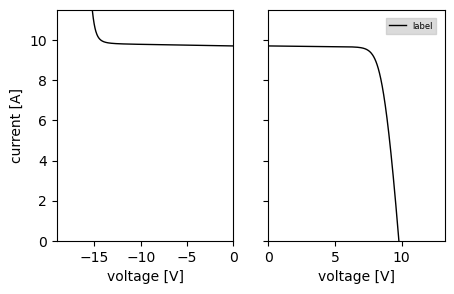

In [263]:
ipv_plot.plot_curves([i], [v], module_dict['Parameters'])

In [402]:
building.solve_all_modules_iv_curve(surface)

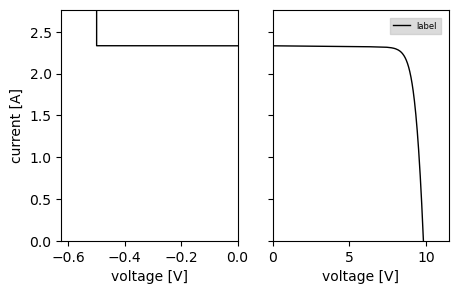

In [403]:
mod = 9
module_dict = building.get_dict_instance([surface,building.get_modules(surface)[mod]])
module_curves = module_dict['Curves']

hoy = 999
ipv_plot.plot_curves([module_curves['Imod'][hoy]], [module_curves['Vmod'][hoy]], module_dict['Parameters'])


In [405]:
res = method_topology_solver.solve_micro_inverter_mpp(building, module_dict)
res[999]

{'imp': 2.225,
 'vmp': 8.519,
 'pmp': 18.955,
 'isc': {},
 'voc': {},
 'ff': {},
 'irrad': 85.694,
 'eff': 0.221}